## Three-dimensional hyperbolic systems

### Navier Stokes equation in 3d

First we are going to study the three-dimensional Navier-Stokes equation 
\begin{align}
    \frac{\partial}{\partial t} n &= - \nabla\cdot\left( nu\vec { b}\right) \\
    \frac{\partial}{\partial t} u &= - \nabla_\parallel\left(\frac{u^2}{2}\right) - \frac{\tau}{\mu} \frac{\nabla_\parallel n}{n} + \nu_u \frac{\Delta_\parallel u}{n}
\end{align}
with
\begin{align}
\Delta_\parallel u &= \nabla\cdot ( \vec {b}\vec {b}\cdot\nabla u)
\end{align} 
$\vec {b} = \vec {b}(\vec x)$ is the prescribed magnetic field unit vector,
and $\nu_u$ is the viscosity coefficient parallel to this field.

In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import feltorutilities as fp
import magneticfielddb as mag
import simplesimdb as simplesim
from scipy import ndimage

In [2]:
def create_inputfile() :
    inputfile = fp.load_calibration_default()
    inputfile["magnetic_field"]["params"] = mag.select("guenter.json")

    scaleR = [1.0,1.0]
    scaleZ = [1.0,1.0]
    inputfile["grid"] = {"Nx" : 32, "Ny" : 32, "Nz": 20, "n": 3,
                         "scaleR" : scaleR, "scaleZ" : scaleZ}
    inputfile["boundary"]["wall"] = {"type" : "none" }
    inputfile["boundary"]["sheath"] = {"type" : "none" }

    inputfile["init"] ={
        "type" : "fields",
        "density": {    
            "type" : "ne",
            "ntilde": {
#                 "type" : "circle", # secret init condition in Feltor
#                 "sigma" : 0.2,
                "type" : "circle",
                "sigma" : 0.2,
                "amplitude" : 1.0,
                "posX" : 0.5,
                "posY" : 0.0,
                "rk4eps" :1e-6,
                "revolutions" : 1,
                "parallel" : "double-step", # secret non-symmetric init condition
                "sigma_z" : 1
            },
            "profile" : {
                "type" : "const",
                "background" : 0.2
            },
            "damping": {
                "type" : "none"
            }
        },
        "potential" : {"type" : "zero_pol"},
        "velocity"  : {"type" : "zero"}, 
        "aparallel" : {"type" : "zero"}
    }
    inputfile["regularization"] = {
        "direction" : "forward",
        "nu_perp_n" : 0,
        "nu_perp_u" : 0,
        "nu_parallel_n"  : 0.0,
        "order" : 2,
        "jfactor" : 1
    }
    inputfile["source"] = {
        "minne" : 0.,
        "type" : "zero"
    }
    inputfile["timestepper"] = {
        "type" : "adaptive",
        "tableau" : "Bogacki-Shampine-4-2-3",
        "rtol" : 1e-4,
        "atol" : 1e-6,
        "output-mode" : "Tend",
        "reject-limit" : 2,
        "Tend" : 10
    }
    inputfile["FCI"]["periodify"] = False
    inputfile["advection"]= {
        "type"  : "staggered-fieldaligned",
        "slope-limiter" : "none"}
    inputfile["physical"]["tau"] = 1.0
    inputfile["physical"]["viscosity"] = "value"
    inputfile["physical"]["nu_parallel"] = [0,0.0]
    inputfile["output"] = {
        "type" : "netcdf",
        "itstp" : 100,
        "maxout" : 1,
        "compression" : [1,1],
        "equations" : [
            "Basic"  ,
            "Mass-conserv",
            "Energy-theorem",
            #"Toroidal-momentum",
            "Parallel-momentum",
            #"Zonal-Flow-Energy",
            #"COCE"
        ]
    }
    inputfile["flags"] = []
    return inputfile

inputfile = create_inputfile()
print("magnetic_field", json.dumps( inputfile["magnetic_field"], indent=4,sort_keys=True))
print("init", json.dumps( inputfile["init"], indent=4,sort_keys=True))
print("advection", json.dumps( inputfile["advection"], indent=4,sort_keys=True))

magnetic_field {
    "curvmode": "toroidal",
    "input": "params",
    "params": {
        "I_0": 10.0,
        "R_0": 3.0,
        "comment": "Sine functions; Guenter et al, J. Comput. Phys. 209 (2005) 354",
        "description": "square",
        "equilibrium": "guenter"
    }
}
init {
    "aparallel": {
        "type": "zero"
    },
    "density": {
        "damping": {
            "type": "none"
        },
        "ntilde": {
            "amplitude": 1.0,
            "parallel": "double-step",
            "posX": 0.5,
            "posY": 0.0,
            "revolutions": 1,
            "rk4eps": 1e-06,
            "sigma": 0.2,
            "sigma_z": 1,
            "type": "circle"
        },
        "profile": {
            "background": 0.2,
            "type": "const"
        },
        "type": "ne"
    },
    "potential": {
        "type": "zero_pol"
    },
    "type": "fields",
    "velocity": {
        "type": "zero"
    }
}
advection {
    "slope-limiter": "none",
    "type"

In [3]:
rep = simplesim.Manager( executable="./feltor.sh", directory="ThreeDimensional/calibrate", filetype="nc")

In [4]:
def plot2d (f, save = False, field = "Mass") :
    ncin = Dataset( simulator.select(f), 'r', format="NETCDF4")
    # time, xc, yc, vorticity, potential,
    # error(t), time_per_step(t), energy_1d(t), enstrophy_1d(t), vorticity_1d(t)
    max_idx = ncin.variables["time"].shape[0]-1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc,yc = np.meshgrid( x, y)
    vol = ncin["vol2d"][:,:]*2*np.pi
    time = ncin["time"][:]
    max_idx = np.size( time)-1
    nsteps = ncin.variables["nsteps"][max_idx]

    fig,ax=plt.subplots(1,2,figsize=(2*8,8),dpi= 80, facecolor='w', edgecolor='k')
    
    lower = 0.15
    upper = 0.225

    lower = 0.1
    upper = 0.7
    lower = 0.15
    upper = 0.225
#     lower = -0.1
#     upper = +0.1
    im = ax[0].pcolormesh(xc,yc,ncin['ions_2d'][max_idx,:,:],
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='jet' )
    ax[0].axis('scaled')
    ax[0].set_title("Mass")
    vo = ncin['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[max_idx,:,:]*vol )
#     print( "Total Mass0 ", mass0)
#     print( "Total Mass1 ", mass1)
    vo = ncin['nilnni_ta2d'][:,:,:] + ncin["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[max_idx,:,:]*vol )
    energy_diss_tt = np.sum( ncin['leiparallel_tt_ta2d'][1:max_idx+1,:,:], axis=0)
    energy_diss1 = np.sum( energy_diss_tt[:,:]*vol) 
    print( "Energy diss ", energy_diss1)
    textstr = '\n'.join((
    r'$%.d \times %.d \times %.d \times %.d $   $(n \times N_x \times N_z \times N_T )$' % (
        f["grid"]["n"], f["grid"]["Nx"], f["grid"]["Nz"],nsteps  ),
        r'$T_{end}=%.2d$' % time[max_idx],
        '',
    'Relative error in conserved quantities:',
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1+energy_diss1)/energy0),
                '',
    'interpolation/projection : ' + f["FCI"]["interpolation-method"] ,
    'advection                : ' + f["advection"]["type"] ,
    'nu_parallel              : ' + (r" $%.1f$"%f["physical"]["nu_parallel"][1]
    ), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, textstr, transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    #ax[1].set_title( f["grid"]["n"])
    
#     fig.colorbar(im, ax=ax[0])
    ax[1].axis('off')
    if save :
        hashed = simulator.hashinput(f)
        plt.savefig( "pics/"+hashed+".png",bbox_inches='tight')
        plt.close()
    else :
        pass

In [5]:
# Define a plotting routine for the conservation equations
def plot_mass( simfile,  plotfile, index, save="", vmin=0.2, vmax=0.8):
    plt.rcParams.update({'font.size': 14})

    fig,ax=plt.subplots(1,2,figsize=(2*1.25*6,1*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(simset.inputfile)
    x = simset["x"][:]
    y = simset["y"][:]
    xc,yc = np.meshgrid( x, y)
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    
    vol = simset["vol2d"][:,:]*2*np.pi
    ##
    time = simset['time'][:]
    print( f"file : {simfile}")
    print( f"scheme = {pp['advection']['type']}", end=" ")
    print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
    print(f"time = {time[index]:5.2f}")
    gg = pp["grid"]
    fci = pp["FCI"]
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}", end='')
    print( f", nsteps: {simset['nsteps'][index]}, nfailed: {simset['failed'][index]}")
    
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################
    ####################################################################


    lower = vmin
    upper = vmax
    vo = simset['ions_2d'][index,:,:]
    im = ax[0].pcolormesh(xc,yc,vo,
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='gist_heat_r' )
    ax[0].axis('scaled')
    ax[0].set_xlabel(r'$R$')
    ax[0].set_ylabel(r'$Z$')
    vo = simset['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[index,:,:]*vol )
#     print( "Relative Mass error ", ((mass0-mass1)/mass0))
    vo = simset['nilnni_ta2d'][:,:,:] + simset["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[index,:,:]*vol )
#     print( "Relative Energy error ", ((energy0-energy1)/energy0)
    nsteps = simset.variables["nsteps"][index]
    textstr = '\n'.join((
    r'$%.d \times %.d \times %.d \times %.d $   $(n \times N_x \times N_z \times N_T )$' % (
        pp["grid"]["n"], pp["grid"]["Nx"], pp["grid"]["Nz"],nsteps  ),
        r'$T_{end}=%.2d$' % time[index],
        '',
    'Relative error in conserved quantities:',
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1)/energy0),
                '',
    'interpolation/projection : ' + pp["FCI"]["interpolation-method"] ,
    'advection                : ' + pp["advection"]["type"] ,
    'nu_parallel              : ' + (r" $%.1f$"%pp["physical"]["nu_parallel"][1]
    ), 
    ))
    print(textstr)
    boxstr = '\n'.join((
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1)/energy0), 
    ))
    fig.colorbar( im , ax=ax[0])
    
    ax[1].plot( zf, plotset["ionsFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    ax[1].set_xlabel(r'$\Phi$')
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     ax[1].text(0.05, 0.95, boxstr, transform=ax[1].transAxes, fontsize=16,
#         verticalalignment='top', bbox=props)
    simset.close()
    plotset.close()
    
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    
    plt.show()

In [6]:
def plot_velocity( simfile,  plotfile, index, save="", vmin=0.2, vmax=0.8):
    plt.rcParams.update({'font.size': 14})

    fig,ax=plt.subplots(1,2,figsize=(2*1.25*6,1*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    simset = Dataset( simfile, 'r', format="NETCDF4")
    plotset = Dataset( plotfile, 'r', format="NETCDF4")
    pp = json.loads(simset.inputfile)
    x = simset["x"][:]
    y = simset["y"][:]
    xc,yc = np.meshgrid( x, y)
    # 3d plot section
    xf = plotset["xf"][:]
    yf = plotset["yf"][:]
    zf = plotset["zf"][:]
    xfc2d = np.kron( np.ones(np.shape(zf)),xf).reshape( (np.size(zf), np.size(xf)))
    zfc2d = np.kron( zf, np.ones(np.shape(xf))).reshape( (np.size(zf), np.size(xf)))
    sectionY = pp["grid"]["Ny"]*pp["grid"]["n"]/2
    middleX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.5)/2 
    rightX = pp["grid"]["Nx"]*pp["grid"]["n"]*(1+0.71)/2
    ##
    time = simset['time'][:]
    ###
    lower = vmin
    upper = vmax
    vo = simset['Ui_2d'][index,:,:]
    im = ax[0].pcolormesh(xc,yc,vo,
                          vmin=lower, vmax=upper,
                          shading='gouraud', cmap='seismic' )
    ax[0].axis('scaled')
    ax[0].set_xlabel(r'$R$')
    ax[0].set_ylabel(r'$Z$')
    fig.colorbar( im , ax=ax[0])
    
    ax[1].plot( zf, plotset["UiFF"][index, :, sectionY, middleX], ls = '-', color='r', lw = 4)
    ax[1].set_xlabel(r'$\Phi$')
    
    vol = simset["vol2d"][:,:]*2*np.pi
    vo = simset['ions_ta2d'][:,:,:]
    mass0 = np.sum( vo[0,:,:]*vol )
    mass1 = np.sum( vo[index,:,:]*vol )
#     print( "Relative Mass error ", ((mass0-mass1)/mass0))
    vo = simset['nilnni_ta2d'][:,:,:] + simset["niui2_ta2d"][:,:,:]
    energy0 = np.sum( vo[0,:,:]*vol )
    energy1 = np.sum( vo[index,:,:]*vol )
    energy_diss_tt = np.sum( simset['leiparallel_tt_ta2d'][1:index+1,:,:], axis=0)
    energy_diss1 = np.sum( energy_diss_tt[:,:]*vol)  
    print( "Energy diss ", energy_diss1)
#     print( "Relative Energy error ", ((energy0-energy1)/energy0)
    vo = simset['niui_ta2d'][:,:,:]
    mom0 = np.sum( vo[0,:,:]*vol )
    mom1 = np.sum( vo[index,:,:]*vol )
    mom_diss_tt = np.sum( simset['sparmirrori_tt_ta2d'][1:index+1,:,:], axis=0)
    mom_diss1 = np.sum( mom_diss_tt[:,:]*vol)   
    print( "Momentum diss ", mom_diss1)
    nsteps = simset.variables["nsteps"][index]
    boxstr = '\n'.join((
    r'$\varepsilon_M=%.2e$' % ((mass0-mass1)/mass0),
    r'$a_P=%.2e$' % (mom0-mom1+mom_diss1),
    r'$\varepsilon_E=%.2e$' % ((energy0-energy1+energy_diss1)/np.abs(energy0)), 
    ))
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax[1].text(0.05, 0.95, boxstr, transform=ax[1].transAxes, fontsize=16,
        verticalalignment='top', bbox=props)
    
    
    simset.close()
    plotset.close()
    
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    
    plt.show()

In [7]:
def create_default_config():
    configfile = {
        # for feltordiag
        "n": 3,
        "Npsi": 64,
        "Neta": 640,
        "Kphi": 10,
        "fsa" : "toroidal-average",
        # for interpolate in 3d
        "fine-grid-factor" : 2,
        "time-reduction-factor" : 1,
        "diagnostics" : [
            "1dStatics" ,
            "fsa1d",
            "fsa2d",
            #"cta2d",
            #"cta2dX",
            #"fluc2d",
            #"ifs",
            #"std_fsa",
            #"ifs_lcfs",
            #"ifs_norm"
        ]
    }
    return configfile

config = create_default_config()
with open( "config.json", 'w') as f:
    json.dump( config, f,
        sort_keys=True, ensure_ascii=True, indent=4)

In [8]:
simulator = simplesim.Manager( executable="./feltor.sh",
                              directory="ThreeDimensional/data", filetype="nc")
diagnoser = simplesim.Manager( executable="./feltordiag.sh", directory="ThreeDimensional/diag", filetype="nc")
interpolator = simplesim.Manager( executable ="./feltorplot.sh",
                                  directory="ThreeDimensional/plot", filetype = "nc")
# help (simplesim)

### Navier-Stokes equation in 3d

First, let us try to simulate the centered scheme and the velocity-staggered scheme with the linear interpolation scheme. We see that the centered scheme, as expected, produces oscillations (that without parallel diffusion become unstable immediately).

Existing simulation 9c0866...8c3546.nc
Existing simulation 9c0866...8c3546.nc
file : ThreeDimensional/data/9c0866d7df783675f00f5f7d519d406d828c3546.nc
scheme = staggered limiter = none time =  0.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1.0, nfailed: 0.0
$3 \times 32 \times 50 \times 1 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=00$

Relative error in conserved quantities:
$\varepsilon_M=0.00e+00$
$\varepsilon_E=-0.00e+00$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


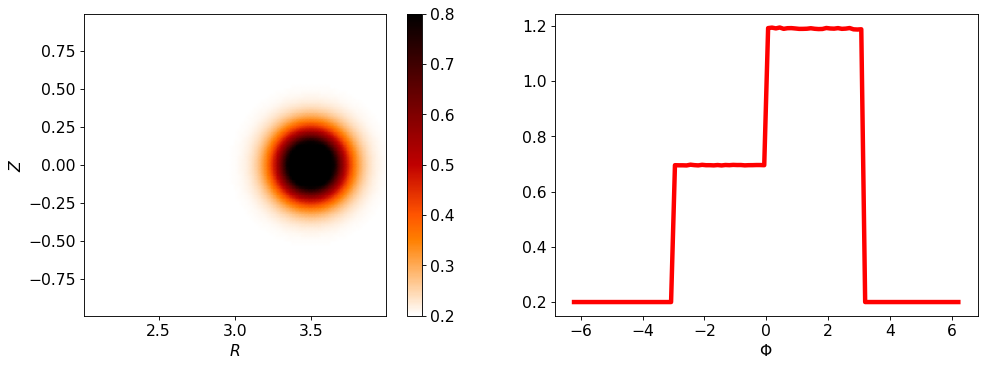

In [9]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3 
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,0,"blob_initial",vmin=0.2, vmax=0.8)

Existing simulation 68f48f...e04b92.nc
Existing simulation 68f48f...e04b92.nc
file : ThreeDimensional/data/68f48fc0d31e8e294db2c4dfe435646f4ce04b92.nc
scheme = staggered-fieldaligned limiter = none time = 20.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 587.0, nfailed: 0.0
$3 \times 32 \times 50 \times 587 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=20$

Relative error in conserved quantities:
$\varepsilon_M=8.26e-05$
$\varepsilon_E=-4.50e-03$

interpolation/projection : linear-nearest
advection                : staggered-fieldaligned
nu_parallel              :  $0.0$


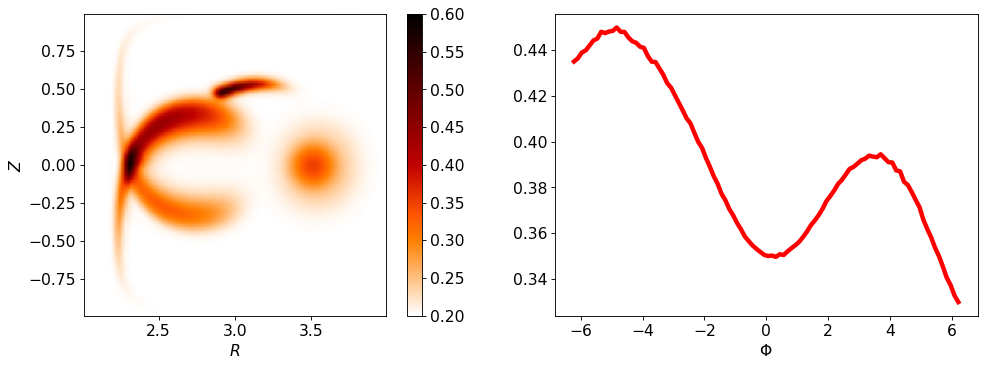

Energy diss  0.0
Momentum diss  -0.00038088724294395825


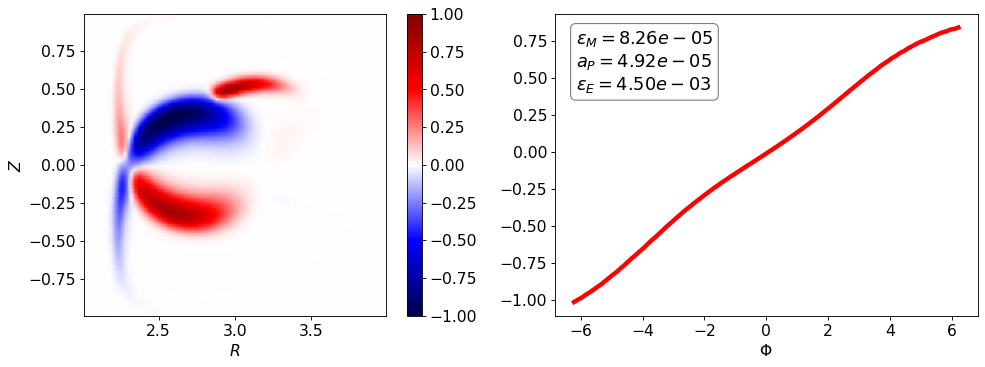

In [10]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simulationfile["timestepper"]["rtol"] = 1e-4
simulationfile["timestepper"]["atol"] = 1e-6
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-fieldaligned-linear-nearest",vmin=0.2, vmax=0.6)
plot_velocity(simfile,plotfile,1,"blob-staggered-fieldaligned-linear-nearest-u",vmin=-1.0,vmax=1.0)

Existing simulation 932e09...2787a1.nc
Existing simulation 932e09...2787a1.nc
file : ThreeDimensional/data/932e090fa590c977766820724395053f6b2787a1.nc
scheme = staggered limiter = none time = 20.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1229.0, nfailed: 0.0
$3 \times 32 \times 50 \times 1229 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=20$

Relative error in conserved quantities:
$\varepsilon_M=2.04e-08$
$\varepsilon_E=-4.59e-03$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


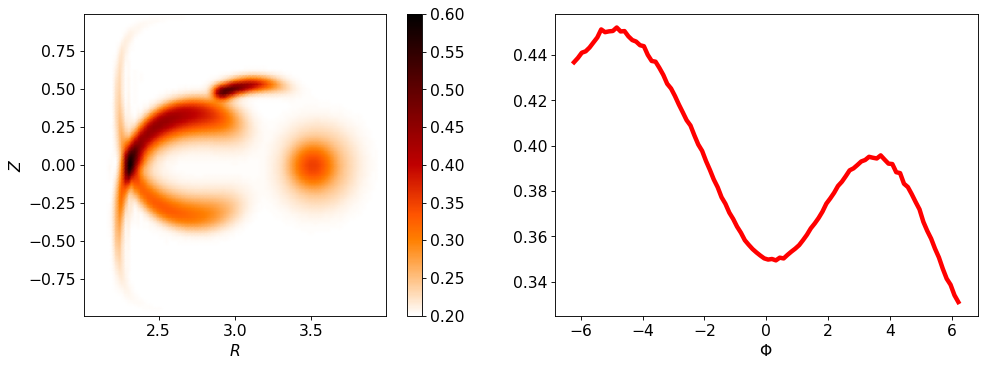

Energy diss  0.0
Momentum diss  -0.0004172618910476192


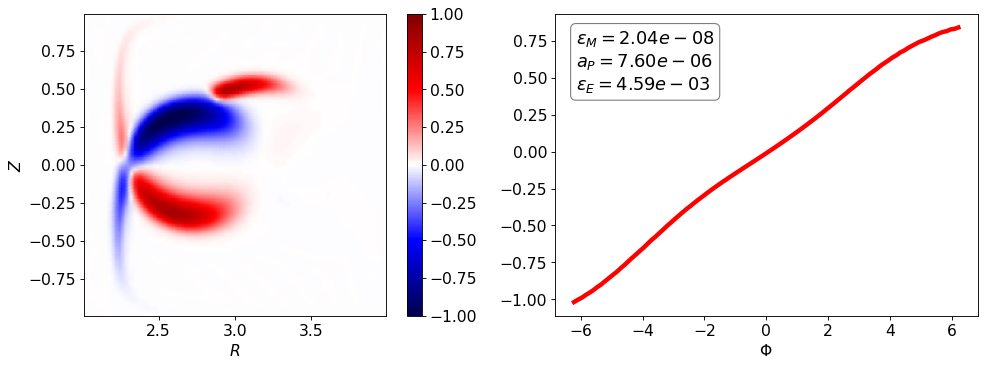

In [11]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simulationfile["output"]["itstp"]=400
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-linear-nearest",vmin=0.2,vmax=0.6)
plot_velocity(simfile,plotfile,1,"blob-staggered-linear-nearest-u",vmin=-1.0,vmax=1.0)

Existing simulation cae841...385597.nc
Existing simulation cae841...385597.nc
file : ThreeDimensional/data/cae84148dc9dab6f808e538c2bf3a19e0e385597.nc
scheme = staggered limiter = none time = 20.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: dg, nsteps: 602.0, nfailed: 0.0
$3 \times 32 \times 50 \times 602 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=20$

Relative error in conserved quantities:
$\varepsilon_M=-1.94e-05$
$\varepsilon_E=-3.65e-03$

interpolation/projection : dg
advection                : staggered
nu_parallel              :  $0.0$


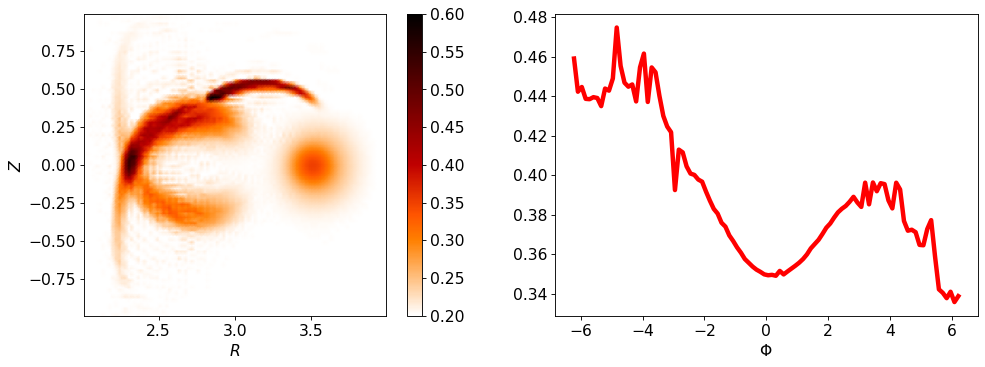

Energy diss  0.0
Momentum diss  -0.0006513609351469743


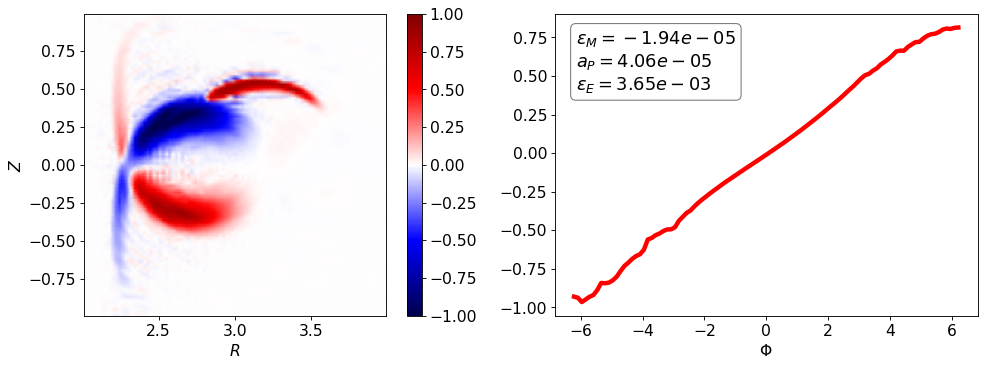

In [12]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "dg"
simulationfile["grid"]["n"] = 3 
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 20
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-dg-12",vmin=0.2,vmax=0.6)
plot_velocity(simfile,plotfile,1,"blob-staggered-dg-12-u",vmin=-1.0,vmax=1.0)

Existing simulation 0545fa...4f167a.nc
Existing simulation 0545fa...4f167a.nc
file : ThreeDimensional/data/0545fac6419749fe92982130c050cd15574f167a.nc
scheme = staggered limiter = none time =  2.46
n: 3, Nx: 32, Nz: 50, mx: 1, method: dg, nsteps: 433.0, nfailed: 30.0
$3 \times 32 \times 50 \times 433 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=02$

Relative error in conserved quantities:
$\varepsilon_M=-8.40e-05$
$\varepsilon_E=-6.25e+05$

interpolation/projection : dg
advection                : staggered
nu_parallel              :  $0.0$


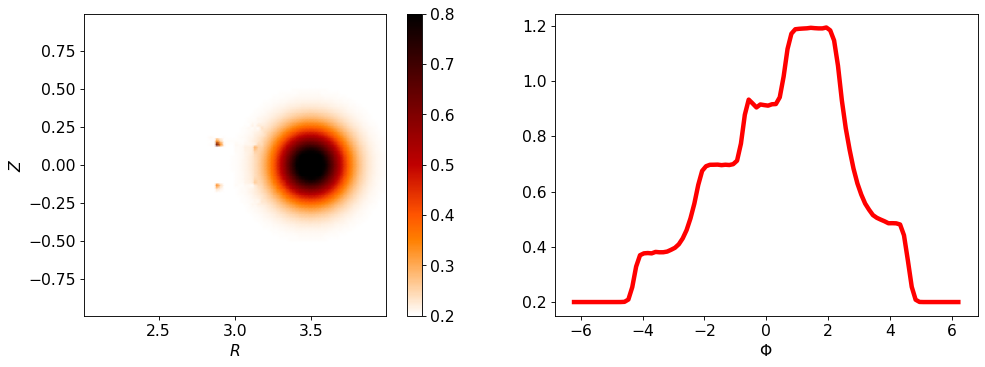

In [13]:
simulationfile = create_inputfile()
simulationfile["advection"]["type"] = "staggered"
simulationfile["init"]["density"]["ntilde"]["type"] = "blob"
simulationfile["init"]["density"]["ntilde"]["sigma"] = 0.15
simulationfile["FCI"]["refine"] = [1,1]
simulationfile["FCI"]["interpolation-method"] = "dg"
simulationfile["grid"]["n"] = 3 
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"blob-staggered-dg-1",vmin=0.2,vmax=0.8)

Now we test the same problem but with the circle initial condition

In [14]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered"
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3 # order 6 makes more oscis
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
# simfile =  simulator.create( simulationfile, error="display")
# plot2d(simulationfile)
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,0,"circle-initial",vmin=0.2,vmax=1.2)

Existing simulation 573dc8...ef4bc1.nc
Existing simulation 573dc8...ef4bc1.nc
file : ThreeDimensional/data/573dc83587d7017251db3ede2416aaf584ef4bc1.nc
scheme = staggered limiter = none time =  0.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1.0, nfailed: 0.0
$3 \times 32 \times 50 \times 1 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=00$

Relative error in conserved quantities:
$\varepsilon_M=0.00e+00$
$\varepsilon_E=-0.00e+00$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


Existing simulation 573dc8...ef4bc1.nc
Existing simulation 573dc8...ef4bc1.nc
file : ThreeDimensional/data/573dc83587d7017251db3ede2416aaf584ef4bc1.nc
scheme = staggered limiter = none time =  8.79
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 1111.0, nfailed: 78.0
$3 \times 32 \times 50 \times 1111 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=08$

Relative error in conserved quantities:
$\varepsilon_M=-1.72e-07$
$\varepsilon_E=-2.68e+13$

interpolation/projection : linear-nearest
advection                : staggered
nu_parallel              :  $0.0$


Energy diss  0.0
Momentum diss  -0.0070256693394516135


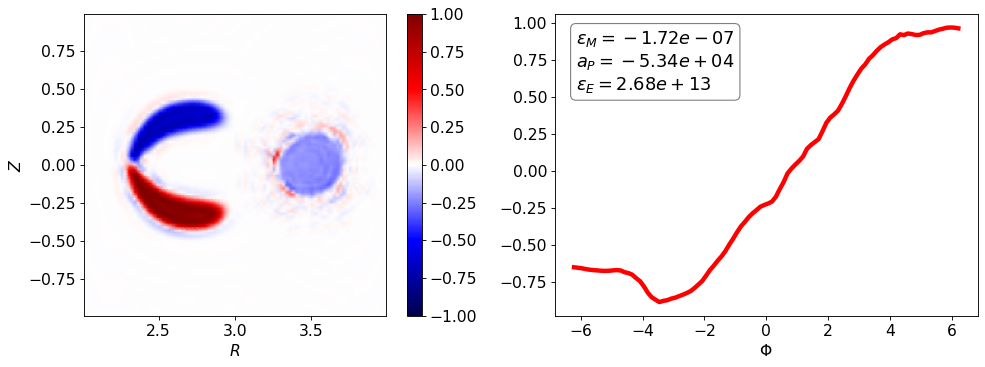

In [15]:
# CRASHES !!!
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered"
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3 # order 6 makes more oscis
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 10
# simulationfile["timestepper"]["tableau"] = "Tsitouras11-7-4-5"
# simfile =  simulator.create( simulationfile, error="display")
# plot2d(simulationfile)
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-staggered-linear-nearest",vmin=0.15,vmax=1.0)
plot_velocity(simfile,plotfile,1,"circle-staggered-linear-nearest-u",vmin=-1.0,vmax=1.0)

Existing simulation 788afa...5a2538.nc
Existing simulation 788afa...5a2538.nc
file : ThreeDimensional/data/788afa2d58449b0270abd9d94ad4c387a05a2538.nc
scheme = staggered-fieldaligned limiter = none time = 30.00
n: 3, Nx: 32, Nz: 50, mx: 12, method: linear-nearest, nsteps: 914.0, nfailed: 0.0
$3 \times 32 \times 50 \times 914 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=30$

Relative error in conserved quantities:
$\varepsilon_M=3.93e-03$
$\varepsilon_E=-1.46e-02$

interpolation/projection : linear-nearest
advection                : staggered-fieldaligned
nu_parallel              :  $0.0$


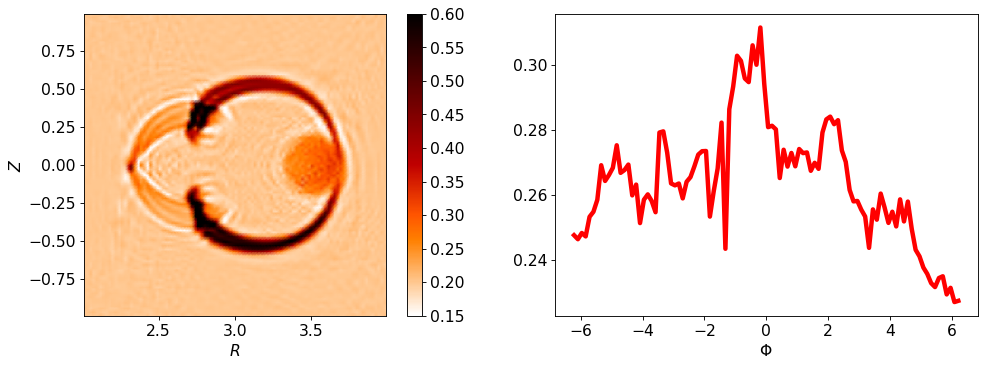

Energy diss  0.0
Momentum diss  -0.007863125710391855


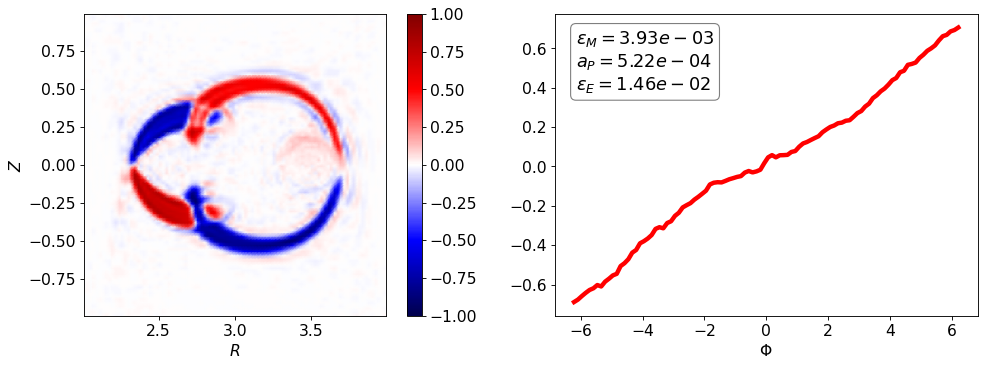

In [16]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-fieldaligned"
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 32
simulationfile["grid"]["Ny"] = 32
simulationfile["grid"]["Nz"] = 50
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 30
# simulationfile["timestepper"]["tableau"] = "Tsitouras11-7-4-5"
# plot2d(simulationfile)
simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-staggered-fieldaligned-linear-nearest",vmin=0.15,vmax=0.6)
plot_velocity(simfile,plotfile,1,"circle-staggered-fieldaligned-linear-nearest-u",vmin=-1.0,vmax=1.0)

The oscillations go away by adding parallel diffusion

Existing simulation dbc1ba...adf4b8.nc
Existing simulation dbc1ba...adf4b8.nc
file : ThreeDimensional/data/dbc1badb3700c36d226faa61376fc4acf2adf4b8.nc
scheme = velocity-staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 1226.0, nfailed: 0.0
$3 \times 50 \times 20 \times 1226 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=6.89e-07$
$\varepsilon_E=-2.32e-02$

interpolation/projection : linear-nearest
advection                : velocity-staggered
nu_parallel              :  $0.2$


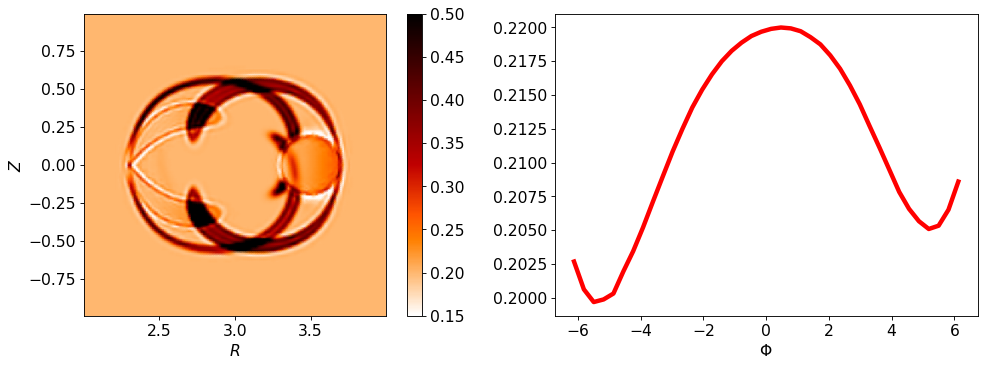

Energy diss  -0.14513755697219852
Momentum diss  -0.007894352565064378


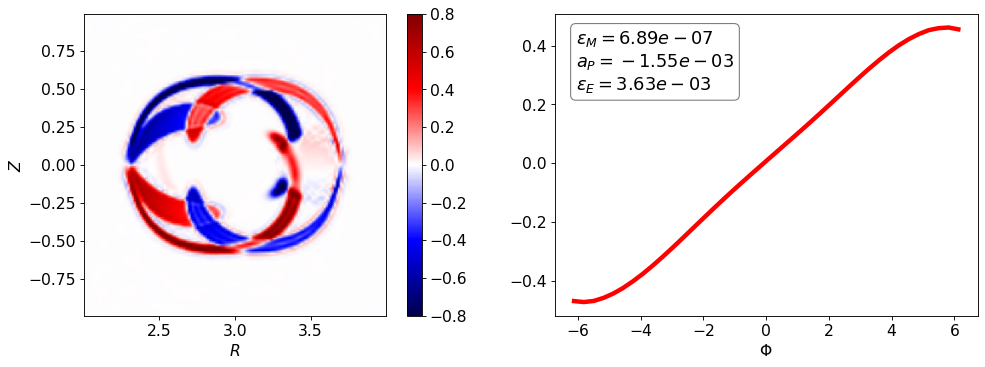

In [17]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["output"]["itstp"]=400


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-velocity-staggered-linear-nearest-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-velocity-staggered-linear-nearest-nu-u",vmin=-0.8,vmax=0.8)

Existing simulation ee5250...4a90d3.nc
Existing simulation ee5250...4a90d3.nc
file : ThreeDimensional/data/ee5250b75da24ad8892c54d50607dcf99e4a90d3.nc
scheme = velocity-staggered-fieldaligned limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 491.0, nfailed: 0.0
$3 \times 50 \times 20 \times 491 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=1.31e-03$
$\varepsilon_E=-2.56e-02$

interpolation/projection : linear-nearest
advection                : velocity-staggered-fieldaligned
nu_parallel              :  $0.2$


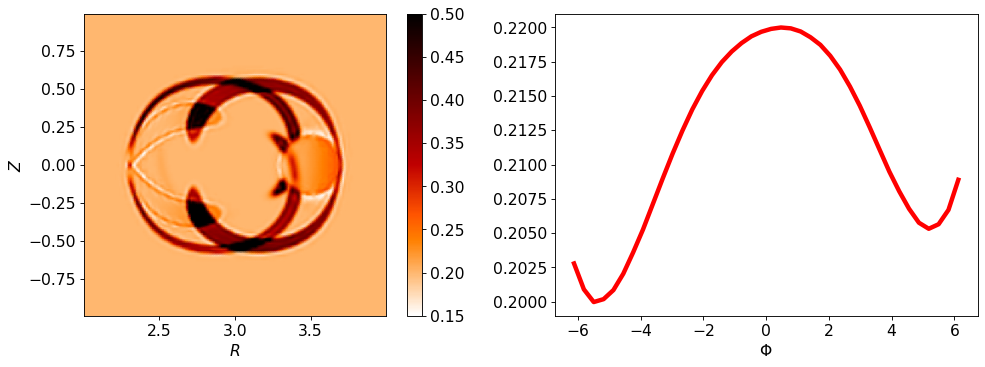

Energy diss  -0.12863555348046207
Momentum diss  -0.008153538991895026


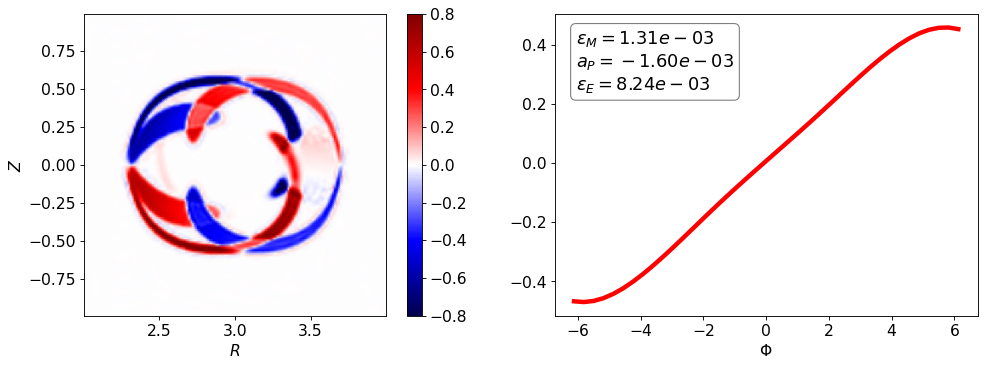

In [18]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered-fieldaligned"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
simulationfile["output"]["itstp"]=100
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-velocity-staggered-fieldaligned-linear-nearest-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-velocity-staggered-fieldaligned-linear-nearest-nu-u",vmin=-0.8,vmax=0.8)

Existing simulation 0ace97...0b8dc7.nc
Existing simulation 0ace97...0b8dc7.nc
file : ThreeDimensional/data/0ace97a69f63517845f27786cad787233d0b8dc7.nc
scheme = velocity-staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: dg, nsteps: 1209.0, nfailed: 73.0
$3 \times 50 \times 20 \times 1209 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=3.19e-06$
$\varepsilon_E=-2.69e-02$

interpolation/projection : dg
advection                : velocity-staggered
nu_parallel              :  $0.2$


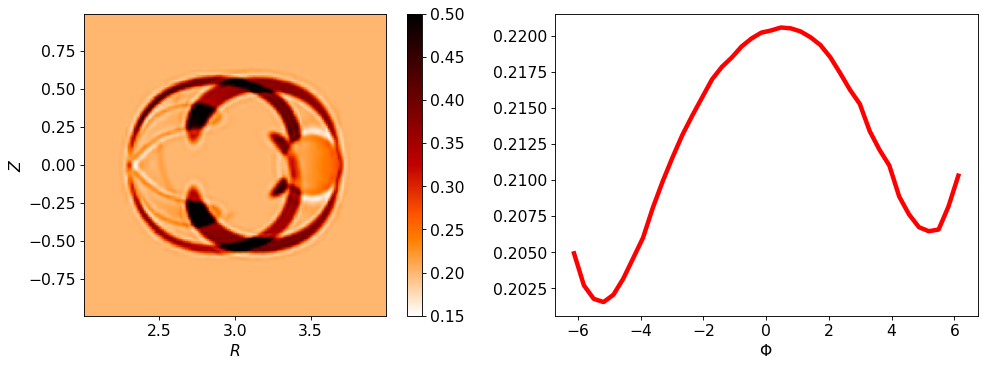

Energy diss  -0.15295540764848012
Momentum diss  -0.008221377929225518


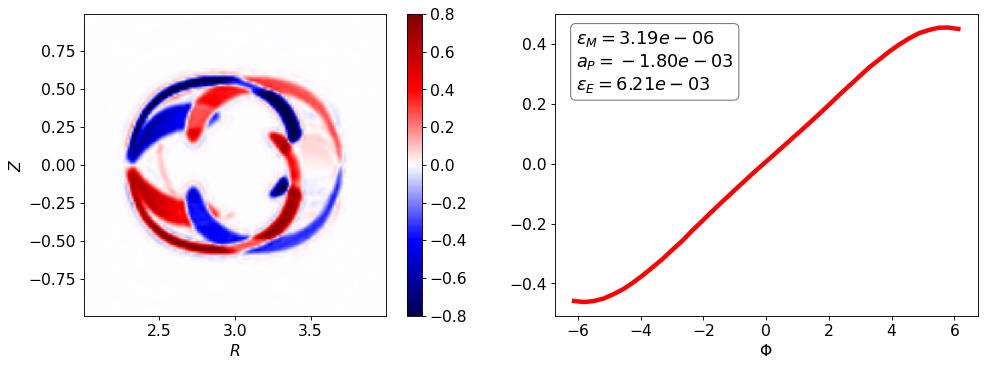

In [19]:
## Does dG still crash?
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "velocity-staggered"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "dg"
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-velocity-staggered-dg-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-velocity-staggered-dg-nu-u",vmin=-0.8,vmax=0.8)

Existing simulation 5608ec...53d225.nc
Existing simulation 5608ec...53d225.nc
file : ThreeDimensional/data/5608ecb6efe0f04a7da3104f8e17ad787f53d225.nc
scheme = staggered-direct limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 600.0, nfailed: 1.0
$3 \times 50 \times 20 \times 600 $   $(n \times N_x \times N_z \times N_T )$
$T_{end}=40$

Relative error in conserved quantities:
$\varepsilon_M=-5.96e-03$
$\varepsilon_E=-1.65e-02$

interpolation/projection : linear-nearest
advection                : staggered-direct
nu_parallel              :  $0.2$


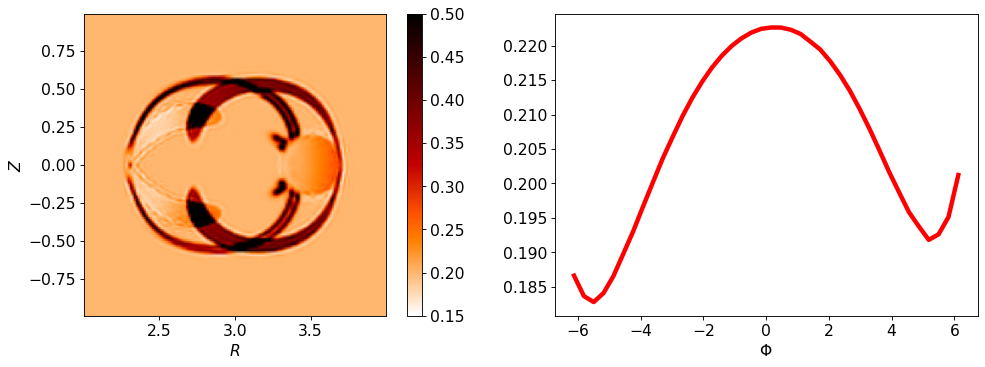

Energy diss  -0.2811911059664749
Momentum diss  -0.007044810452362077


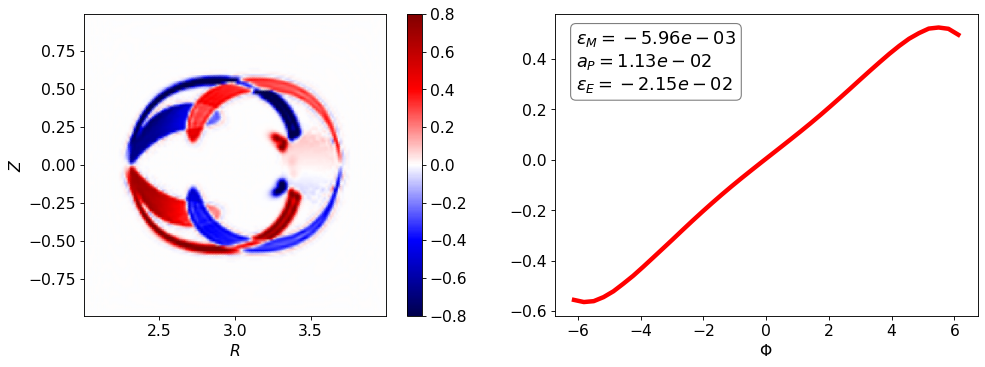

In [20]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["advection"]["type"] = "staggered-direct"
simulationfile["physical"]["nu_parallel"] = [0,0.2]
simulationfile["regularization"]["nu_parallel_n"] = 0.2
simulationfile["FCI"]["refine"] = [12,12]
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 50
simulationfile["grid"]["Ny"] = 50
simulationfile["grid"]["Nz"] = 20
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["advection"]["slope-limiter"] = "none"
simulationfile["timestepper"]["Tend"] = 40
# simfile =  simulator.create( simulationfile)
# plot2d(simulationfile)


simfile =  simulator.create( simulationfile, error="display")
plotfile = interpolator.create( simulationfile, error="display")
plot_mass(simfile,plotfile,1,"circle-staggered-direct-linear-nearest-nu",vmin=0.15,vmax=0.5)
plot_velocity(simfile,plotfile,1,"circle-staggered-direct-linear-nearest-nu-u",vmin=-0.8,vmax=0.8)

### Plot conservation of mass

In [21]:
# Define a plotting routine for the conservation equations
def plot_conservation( simfile_l, plot_velocity = False, save="", vmin=0.2, vmax=0.8):
    plt.rcParams.update({'font.size': 14})
    frows = 1
    fcols = 1
    if plot_velocity :
        fcols = 2
    
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*1.25*6,frows*1.25*4),dpi= 80, facecolor='w', edgecolor='k')
    
    for simfile in simfile_l :
        simset = Dataset( simfile[0], 'r', format="NETCDF4")
        pp = json.loads(simset.inputfile)

        vol = simset["vol2d"][:,:]*2*np.pi
        time = simset['time'][:]
        print( f"file : {simfile}")
        print( f"scheme = {pp['advection']['type']}", end=" ")
        print( f"limiter = {pp['advection']['slope-limiter']}", end=" ")
        print(f"time = {time[np.size(time)-1]:5.2f}")
        gg = pp["grid"]
        fci = pp["FCI"]
        print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
        print( f", method: {fci['interpolation-method']}", end='')
        print( f", nsteps: {simset['nsteps'][np.size(time)-1]}, nfailed: {simset['failed'][np.size(time)-1]}")

        ####################################################################
        ####################################################################
        ####################################################################
        ####################################################################
        ####################################################################
        ####################################################################


        lower = vmin
        upper = vmax
        vo = simset['ions_ta2d'][:,:,:]
        mass0 = np.sum( vo[0,:,:]*vol )
        mass = np.sum( vo[:,:,:]*vol, axis=(1,2) )
    #     print( "Relative Mass error ", ((mass0-mass1)/mass0))
        vo = simset['nilnni_ta2d'][:,:,:] + simset["niui2_ta2d"][:,:,:]
        energy0 = np.sum( vo[0,:,:]*vol )
        energy = np.sum( vo[:,:,:]*vol, axis=(1,2) )
        energy_diss_tt = np.sum( simset['leiparallel_tt_ta2d'][1:,:,:]*vol,axis=(1,2)) 
        energy_diss1 = np.cumsum( energy_diss_tt)
        energy_diss1 = np.append(0, energy_diss1) 
#         print( "Energy diss ", energy_diss1)
        
    #     print( "Relative Energy error ", ((energy0-energy1)/energy0)
        vo = simset['niui_ta2d'][:,:,:]
        mom0 = np.sum( vo[0,:,:]*vol )
        mom = np.sum( vo[:,:,:]*vol, axis = (1,2) )
        mom_diss_tt = np.sum(simset['sparmirrori_tt_ta2d'][1:,:,:]*vol,axis=(1,2))
        mom_diss1 = np.cumsum( mom_diss_tt[:] )
        mom_diss1 = np.append(0, mom_diss1)

        l = f"{pp['advection']['type']}"
        if pp['advection']['type'] == "velocity-staggered" :
            l = "velocity-staggered flux-centred"
        if pp['advection']['type'] == "velocity-staggered-fieldaligned" :
            l = "velocity-staggered value-centred"
        if pp['advection']['type'] == "staggered-direct":
            l = "staggered-direct"
        if pp['advection']['type']== "staggered":
            l = "staggered flux-centred (dg)"
        
        if plot_velocity :
            ax[0].plot( time, ((mass0-mass)/mass0), ls = '-', color=simfile[1], lw = 4, label = l)
            ax[1].plot( time, (mom0- mom + mom_diss1), ls = ':', color=simfile[1], lw = 4, label = l)
            ax[1].plot( time, ((energy0-energy + energy_diss1)/np.abs(energy0)), ls = '--', color=simfile[1],
                       lw = 4, label = l)
#             ax[1].plot( time, ((mom0-mom+mom_diss1)), ls = '-', color=simfile[1],
#                        lw = 4, label = l)
        else :
            ax.plot( time, ((mass0-mass)/mass0), ls = '-', color=simfile[1], lw = 4, label = l)
        simset.close()
    
    if plot_velocity:
        ax[0].set_xlabel(r'$t$')
        ax[1].set_xlabel(r'$t$')
        ax[0].set_xscale('log')
        ax[0].set_ylim([-1e-2,1e-2])
        ax[0].set_yscale('symlog',linthresh=1e-7)
        ax[0].set_ylabel(r"$\varepsilon_M$")
        ax[1].set_ylabel(r"$\varepsilon_E$, $a_P$")
        ax[1].set_xscale('log')
        ax[1].set_yscale('symlog',linthresh = 1e-3)
        ax[1].set_ylim([-1e-1,1e-1])
        ax[0].legend(loc = "lower right",bbox_to_anchor=(1.0,0.125))
        ax[0].grid(axis="y")
        ax[1].grid(axis="y")
    else :
        ax.set_xlabel(r'$t$')
        ax.set_xscale('log')
        ax.set_yscale('symlog')
        ax.set_ylabel(r"$\varepsilon_M$")
        ax.legend()
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#     ax[1].text(0.05, 0.95, boxstr, transform=ax[1].transAxes, fontsize=16,
#         verticalalignment='top', bbox=props)
    
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    
    plt.show()

Existing simulation 215aaa...df1c9a.nc
Existing simulation 8d77ec...b99604.nc
Existing simulation 4d9333...d7aabb.nc
Existing simulation 0ca67f...8a82f7.nc
file : ('ThreeDimensional/data/215aaa23b172e5a2ae3f66af11c2df35e4df1c9a.nc', 'c')
scheme = staggered-direct limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 1214.0, nfailed: 0.0
file : ('ThreeDimensional/data/8d77ec1f7b5eaa0b6f4be9284c264c359bb99604.nc', 'b')
scheme = velocity-staggered-fieldaligned limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest, nsteps: 1226.0, nfailed: 0.0
file : ('ThreeDimensional/data/4d9333148a466341e98d29420e4121531ad7aabb.nc', 'g')
scheme = staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: dg, nsteps: 1226.0, nfailed: 0.0
file : ('ThreeDimensional/data/0ca67f4f6fcec8ee399268800a4e19714e8a82f7.nc', 'm')
scheme = velocity-staggered limiter = none time = 40.00
n: 3, Nx: 50, Nz: 20, mx: 12, method: linear-nearest,

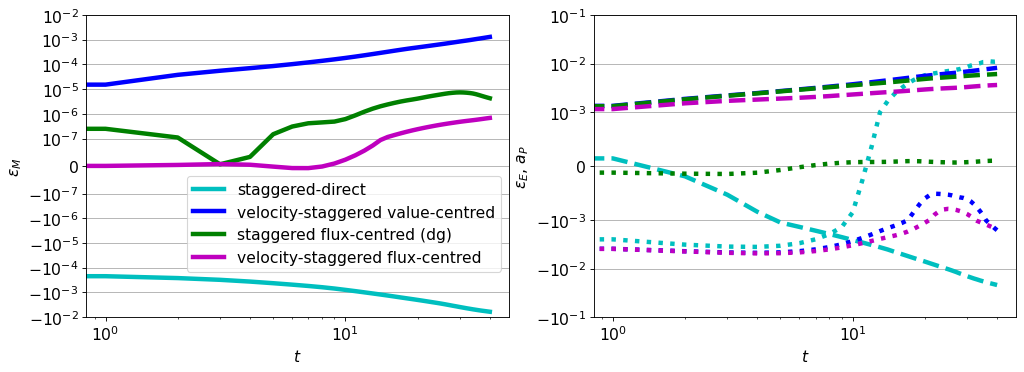

In [22]:
simfile_l = list()
for t in [ ("staggered-direct", "c", "linear-nearest"),
           ("velocity-staggered-fieldaligned","b", "linear-nearest"),
           ("staggered", "g", "dg" ),
           ("velocity-staggered", "m", "linear-nearest")]:
    #for K in [6,12]:
    K=12
    simulationfile = create_inputfile()

    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = t[0]
    simulationfile["physical"]["nu_parallel"] = [0,0.2]
    simulationfile["regularization"]["nu_parallel_n"] = 0.2
    simulationfile["FCI"]["refine"] = [K,K]
    simulationfile["FCI"]["interpolation-method"] = t[2]
    simulationfile["grid"]["n"] = 3
    simulationfile["grid"]["Nx"] = 50
    simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = 20
    simulationfile["advection"]["slope-limiter"] = "none"
    simulationfile["timestepper"]["Tend"] = 40
    simulationfile["output"]["itstp"] = 10
    simulationfile["output"]["maxout"] = 40
    # simfile =  simulator.create( simulationfile)
    # plot2d(simulationfile)

    simfile_l.append( (simulator.create( simulationfile, error="display"), t[1]))
# plot_conservation(simfile_l, plot_velocity=False,save='mass_conservation')
plot_conservation(simfile_l, plot_velocity=True,save='mass_conservation')

### Fieldaligned derivatives
In this experiment we initialize a disc in the plane at $\varphi=0$. 
Then, we transform the disc along the fieldlines half around the torus in both directions.
We can then apply the FCI derivative. Analytically $\nabla_\parallel f=0$ except at both ends of the disc
where the derivatives diverge.

In the following we see that this is not true numerically.

In [23]:
def plot_lparallel( simulationfile, save=""):
    simfile = rep.create( simulationfile)
    ncin = Dataset( simfile, 'r', format="NETCDF4")
    pp = json.loads(ncin.inputfile)
    gg = pp["grid"]
    fci = pp["FCI"]
    
    print( f"{simfile}")
    print( f"n: {gg['n']}, Nx: {gg['Nx']}, Nz: {gg['Nz']}, mx: {fci['refine'][0]}", end='')
    print( f", method: {fci['interpolation-method']}")
    frows = 1
    fcols = 1
    x = ncin["x"][:]
    y = ncin["y"][:]
    xc, yc = np.meshgrid( x, y)
    
    fig,ax=plt.subplots(frows,fcols,figsize=(fcols*12,frows*9),dpi= 80, facecolor='w', edgecolor='k')
    im = ax.pcolormesh(xc, yc, ncin["lparallelinv_ta2d"][0,:,:],
                       vmin=0, vmax=0.08,
                       cmap="gist_heat_r", shading="gouraud") 
    fig.colorbar(im, ax=ax)
    ax.axis("scaled")
    ax.set_xlabel( r"$R$")
    ax.set_ylabel( r"$Z$")
    if save :
        plt.savefig( "pics/"+save+".png",bbox_inches='tight')
    plt.show()

Existing simulation c03bde...f0f53f.nc
ThreeDimensional/calibrate/c03bdec75f232dddfbbd1eb2763c7658c3f0f53f.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: dg


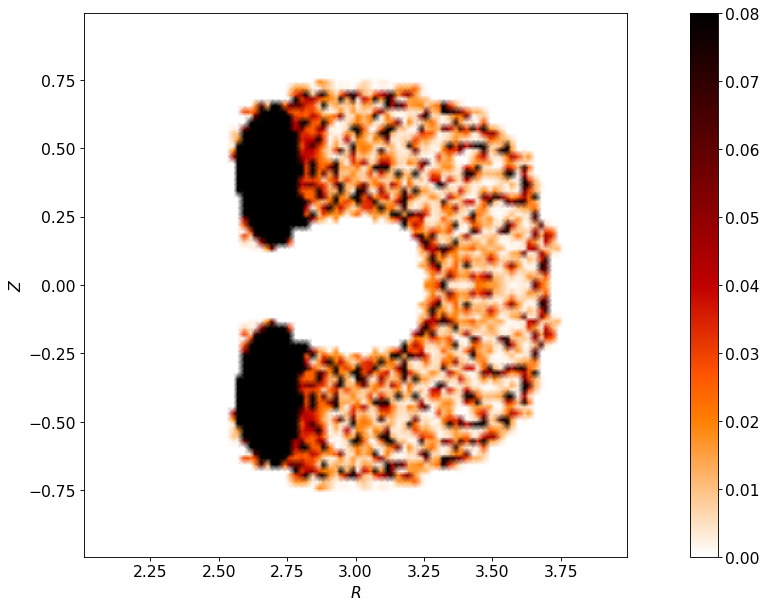

Existing simulation 873814...d4c89b.nc
ThreeDimensional/calibrate/873814747fd133f834bbc8c7d372983c21d4c89b.nc
n: 3, Nx: 32, Nz: 20, mx: 12, method: dg


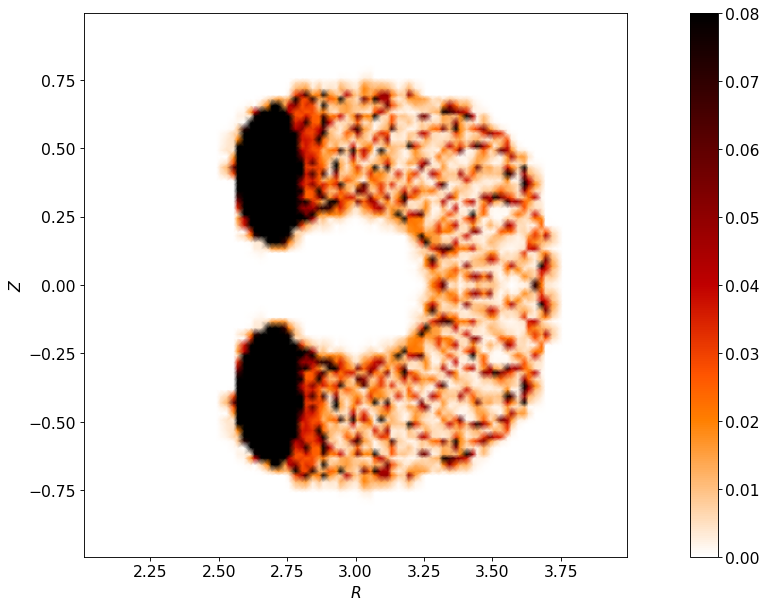

In [24]:
for method in ["dg"]:
    for mx in [1,12]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["init"]["density"]["ntilde"]["type"]="circle"
        simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]
        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot_lparallel(simulationfile,save="lparallel-dg-"+str(mx))

We now change the interpolation method to a bi-linear one, hoping that
less oscillations appear.

In [25]:
for method in ["linear-nearest"]:
    for mx in [1,12]:
        simulationfile = create_inputfile()
        simulationfile["flags"] = []
        simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
        simulationfile["init"]["density"]["ntilde"]["type"]="circle"
        simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
        simulationfile["output"]["maxout"] = 0
        simulationfile["advection"]["type"] = "centered"
        simulationfile["physical"]["nu_parallel"] = [0,1]

        simulationfile["FCI"]["refine"] = [mx,mx]
        simulationfile["FCI"]["interpolation-method"] = method
        simulationfile["grid"]["n"] = 3
        simulationfile["grid"]["Nx"] = 32
        simulationfile["grid"]["Ny"] = 32
        simulationfile["grid"]["Nz"] = 20
        plot_lparallel(simulationfile,save="lparallel-linear-nearest-"+str(mx))

Existing simulation 0053a9...37e557.nc
ThreeDimensional/calibrate/0053a99d4b4f4c63f5f36d4f85a320e6ba37e557.nc
n: 3, Nx: 32, Nz: 20, mx: 1, method: linear-nearest


Existing simulation 7dc8a5...39c148.nc
ThreeDimensional/calibrate/7dc8a50f32629edcdbdb8655a7627254a639c148.nc
n: 3, Nx: 32, Nz: 20, mx: 12, method: linear-nearest


We can also try to increase the perpendicular resolution. We see that the oscillations become smaller in size but do not vanish (likely because the step is sharp).

Existing simulation 845ba9...c2cb3b.nc
ThreeDimensional/calibrate/845ba9a0e865045528b1512d3916948fa1c2cb3b.nc
n: 3, Nx: 60, Nz: 20, mx: 1, method: linear-nearest


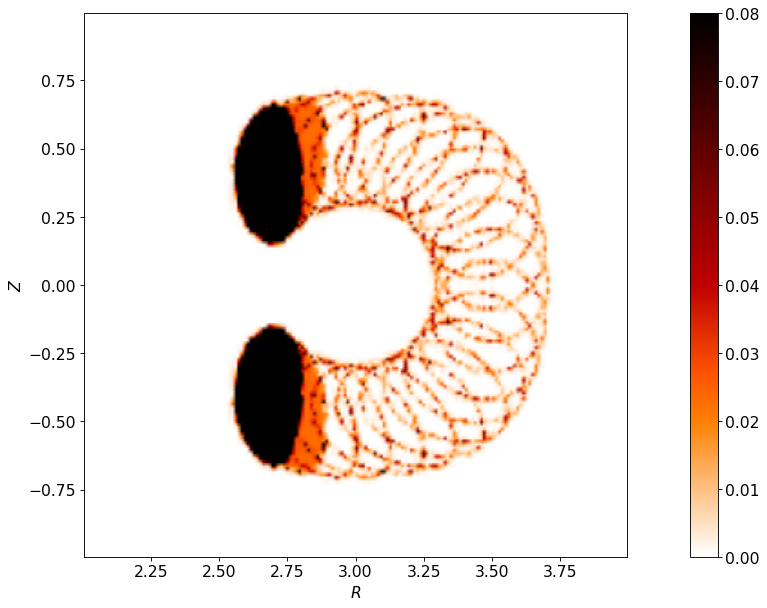

In [26]:
simulationfile = create_inputfile()
simulationfile["flags"] = []
simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
simulationfile["init"]["density"]["ntilde"]["type"]="circle"
simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
simulationfile["output"]["maxout"] = 0
simulationfile["advection"]["type"] = "centered"
simulationfile["physical"]["nu_parallel"] = [0,1]

simulationfile["FCI"]["refine"] = [1,1]
simulationfile["FCI"]["interpolation-method"] = "linear-nearest"
simulationfile["grid"]["n"] = 3
simulationfile["grid"]["Nx"] = 60
simulationfile["grid"]["Ny"] = 60
simulationfile["grid"]["Nz"] = 20
plot_lparallel(simulationfile,"lparallel-linear-nearest-high-res")

We can also try to vary the number of polynomials in the dg interpolation method:
Clearly the higher the polynomial number the more oscillations appear.

Existing simulation 7cc2b4...4e4c0c.nc
ThreeDimensional/calibrate/7cc2b441c174306276bcdc35dd2081bb5f4e4c0c.nc
n: 2, Nx: 50, Nz: 20, mx: 5, method: dg


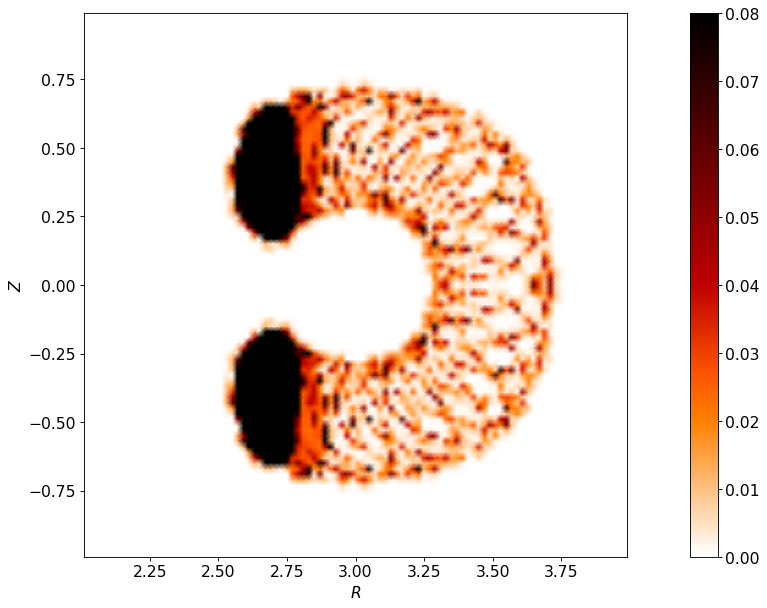

Existing simulation a7f98c...cddb54.nc
ThreeDimensional/calibrate/a7f98cb32cda92b377cc0560ca3ee12b27cddb54.nc
n: 5, Nx: 20, Nz: 20, mx: 5, method: dg


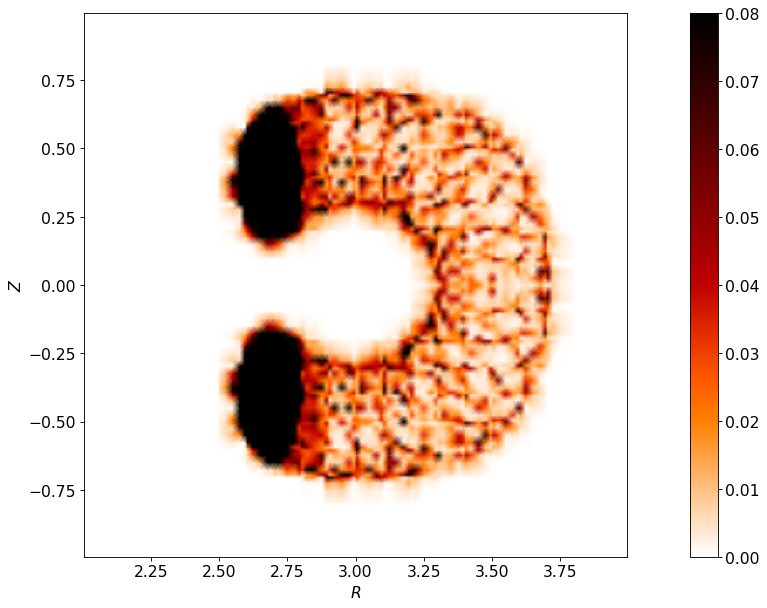

In [27]:
for n in [2,5] :
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["init"]["density"]["ntilde"]["parallel"]="step"
    simulationfile["init"]["density"]["ntilde"]["type"]="circle"
    simulationfile["init"]["density"]["ntilde"]["sigma"]=0.2
    simulationfile["output"]["maxout"] = 0
    simulationfile["advection"]["type"] = "centered"
    simulationfile["physical"]["nu_parallel"] = [0,1]

    simulationfile["FCI"]["refine"] = [5,5]
    simulationfile["FCI"]["interpolation-method"] = "dg"
    simulationfile["grid"]["n"] = n
    simulationfile["grid"]["Nx"] = 20
    simulationfile["grid"]["Ny"] = 20
    if n == 2 :
        simulationfile["grid"]["Nx"] = 50
        simulationfile["grid"]["Ny"] = 50
    simulationfile["grid"]["Nz"] = 20
    plot_lparallel(simulationfile)

### Pure Diffusion test

On the diffusion problem:
- direct diffusion operator is unstable without support operator
- direct diffusion operator is stable with support operator

Existing simulation baa3e7...52e219.nc
Energy diss  -0.23741154714019766
Existing simulation 96813e...9237c2.nc
Energy diss  -0.23599205296049808
Existing simulation 2fa8f7...2053d9.nc
Energy diss  -0.08029600042807322


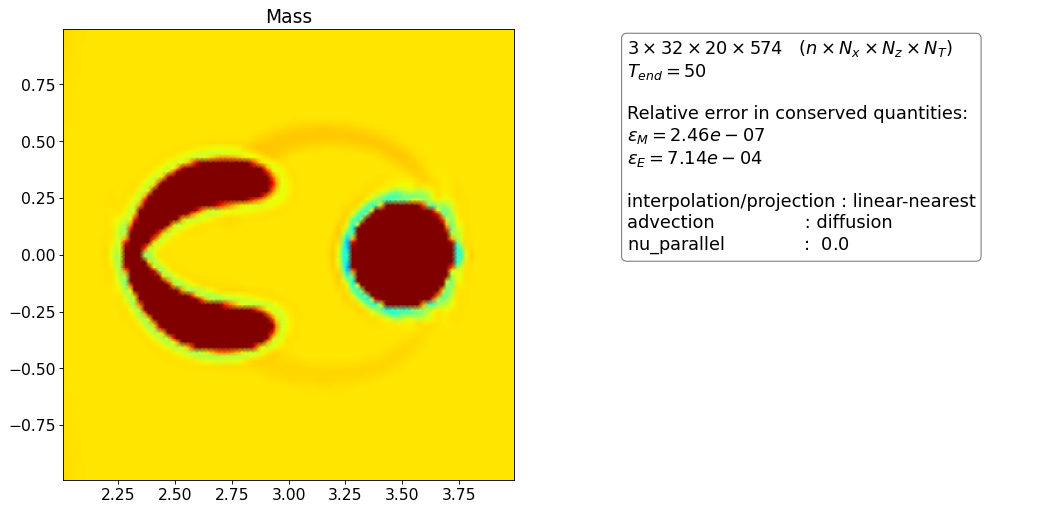

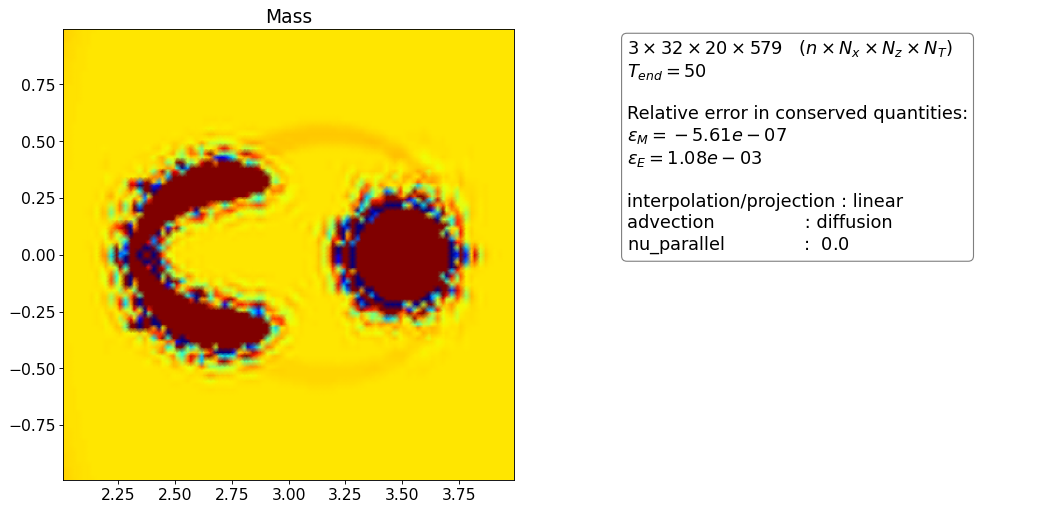

In [28]:
# First test pure diffusion 
for inter in ["dg","linear-nearest","linear"]:
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = "diffusion"
    simulationfile["regularization"]["nu_parallel_n"] = 1
    simulationfile["FCI"]["refine"] = [12,12]
    simulationfile["grid"]["n"] = 3
    simulationfile["grid"]["Nx"] = 32
    simulationfile["grid"]["Ny"] = 32
    simulationfile["grid"]["Nz"] = 20
    simulationfile["timestepper"]["Tend"] = 50
    simulationfile["FCI"]["interpolation-method"] = inter
    
    simfile = simulator.create( simulationfile, error = "display")
    plot2d( simulationfile)

Existing simulation 261b13...ea6fdf.nc
Energy diss  -1.037799155965782
Existing simulation d47417...ad509e.nc
Energy diss  -0.5738057999967019
Existing simulation 952e6e...80f8d6.nc
Energy diss  -0.3957671793254056


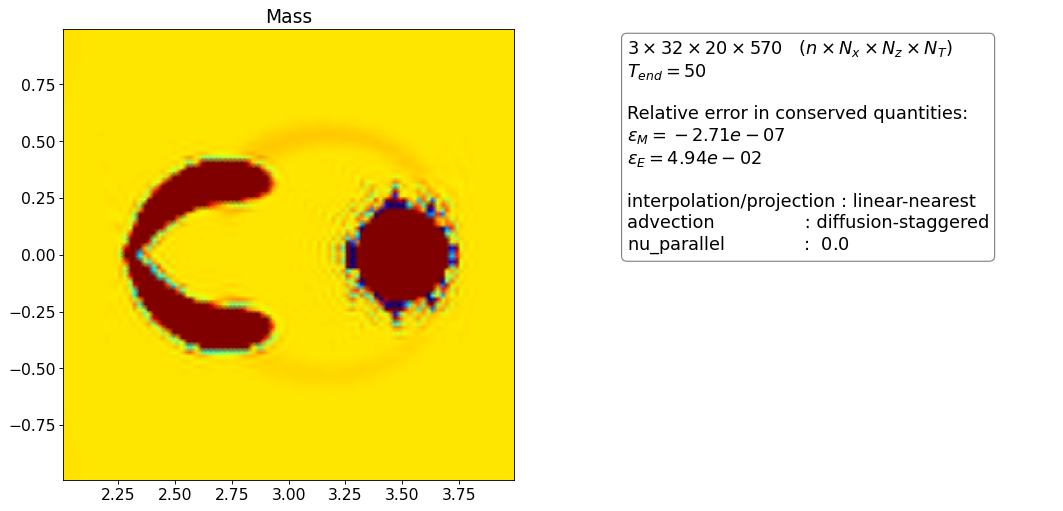

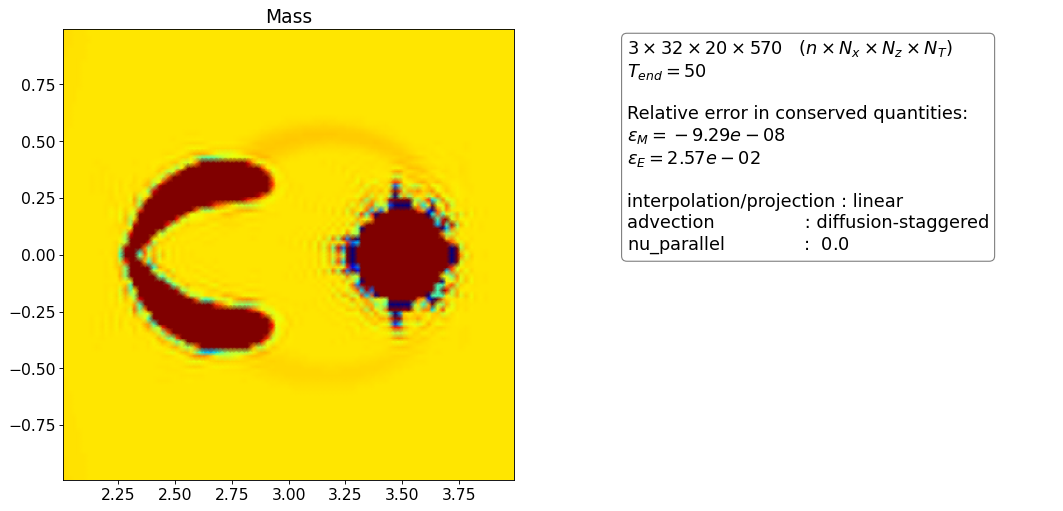

In [29]:
# First test pure diffusion 
for inter in ["dg","linear-nearest","linear"]:
    simulationfile = create_inputfile()
    simulationfile["flags"] = []
    simulationfile["advection"]["type"] = "diffusion-staggered"
    simulationfile["regularization"]["nu_parallel_n"] = 1
    simulationfile["FCI"]["refine"] = [12,12]
    simulationfile["grid"]["n"] = 3
    simulationfile["grid"]["Nx"] = 32
    simulationfile["grid"]["Ny"] = 32
    simulationfile["grid"]["Nz"] = 20
    simulationfile["timestepper"]["Tend"] = 50
    simulationfile["FCI"]["interpolation-method"] = inter
    
    simfile = simulator.create( simulationfile)
    plot2d( simulationfile)